# EDA of Sample Dataset

## Objective
Data Scientists and Analysts are often tasked to clean and analyze datasets. We are working with an external research firm who specializes in the application of artificial intelligence to forecasting prices of financial instruments. This firm has developed a proprietary system, called “4sight”, to forecast prices of certain instruments.

 

To demonstrate the effectiveness of their forecasting system, the vendor has sent us attached sample dataset. The dataset includes signal values generated by the 4sight system as well as historical prices for a well-known broad market ETF.

 

A Portfolio Manager has asked you to:

    1) Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

    2) Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

    3) (Extra credit) Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

    4) Please budget at least one hour for completing this exercise. Please include all the intermediate steps when sending your solution to this exercise back to us.

## Conclusion

Data issues noticed to discuss / inform vendor of:
 - The last six values of Signal are zeros. Why?
    - drop last six rows (or fill forward as the stale value is probably what most systems will end up using)
 - A large outlier of Signal was found on the 2017-11-13. Why?
    - drop row (or fill forward as the stale value is probably what most systems will end up using)
 - Adj Close is very different from Close / Low / High / Open. How was it adjusted?
    - ignore until more confident about the data
 - a large ourlier of Close was found on the 2018-03-19. Why?
    - fill the highest value of Close with the next mornings open
 - 2017-09-08 to 2017-09-22 look to be filled forward for the Close. 
    - fill with Open shifted forward 1 Day
 - high and low inverted on 2018-03-07 and 2018-07-16
    - ignore if you don't plan to test them as features or response
    - if you plan to use them. fill Low with the min of [Open, High, Low, Close] and High with max of [Open, High, Low, Close]
  
On first glance, the signal looks to have no predictive power out of sample (20% of the most recent data). This conclusion was drawn from conducting a residual plot of Signal against Open shifted forward 1 day and Close. To quickly check for some statistical violations the same was done on a tree model which produced similar conclusions.

I'd hold off on doing a lot more analysis as it is unlikely to be valuable on it's own. If we delve further, I would focus on checking the signals power as an interaction term with other features and transforming the problem into a classifier instead of a regression.

## Notebook Setup

In [42]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from pathlib import Path

In [44]:
import sklearn
import interpret
import yellowbrick
import pandas as pd
import numpy as np

from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, RegressionTree
from interpret.perf import RegressionPerf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.features import Rank2D
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.regressor import ResidualsPlot

In [45]:
from pydqc import infer_schema, data_summary, data_compare, data_consist

In [46]:
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"interpret: {interpret.__version__}")
print(f"yellowbrick: {yellowbrick.__version__}")

numpy: 1.19.2
pandas: 1.2.0
sklearn: 0.23.2
interpret: 0.2.2
yellowbrick: 1.2


## Data

In [47]:
eda_dir = Path(".")
data_path = eda_dir / "Sample Dataset.xlsx"
assert data_path.exists() == True

df = pd.read_excel(data_path)
pd.concat([df.dtypes, df.head(1).T, df.tail(1).T], axis=1)

,0,0,1037
Date,datetime64[ns],2015-11-19 00:00:00,2020-01-06 00:00:00
Signal,float64,13.768540,0.000000
Open,float64,116.440002,163.850006
High,float64,116.650002,165.539993
Low,float64,115.739998,163.539993
Close,float64,116.059998,165.350006
Adj Close,float64,108.281601,163.534668


In [48]:
df.describe()

,Signal,Open,High,Low,Close,Adj Close
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000
mean,16.766190,141.847360,142.691801,140.907746,141.840973,136.341060
std,3.095783,18.475574,18.470255,18.404504,18.497010,21.427837
min,0.000000,94.080002,95.400002,93.639999,94.790001,-152.277847
25%,14.691150,132.132496,132.912495,130.542503,131.824993,125.290491
50%,17.298240,146.769997,147.959999,145.634995,146.885002,142.667732
75%,19.030890,155.367496,156.287495,154.422500,155.289993,151.798325
max,35.434147,172.789993,173.389999,171.949997,196.279999,168.842270


**Comments**
- Date looks like the obvious index
- Why is the adj close so far from the close?
- Why is the signal 0 for last entry? Is zero a valid value?
- Why is the max close greater than the max high?

### Check that Date column is unique

In [49]:
df['Date'].value_counts().max()

1

### Review Adj Close

<AxesSubplot:>

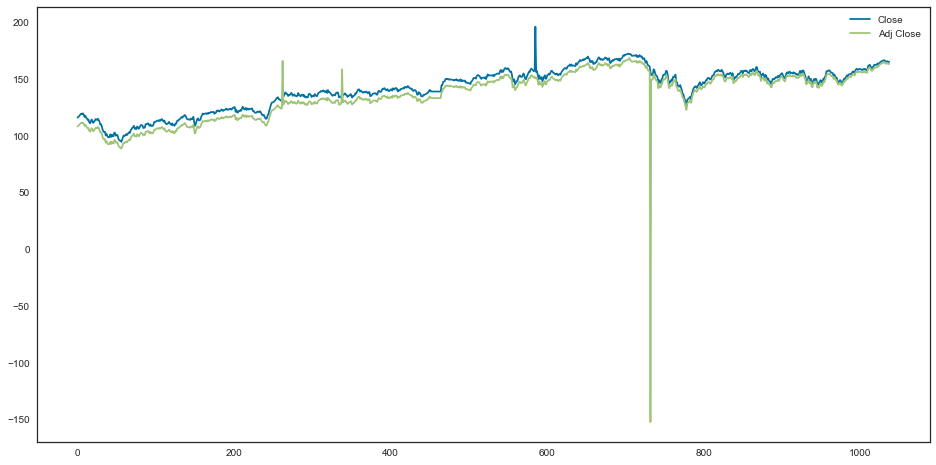

In [50]:
df[['Close', 'Adj Close']].plot(figsize=(16,8))

<AxesSubplot:>

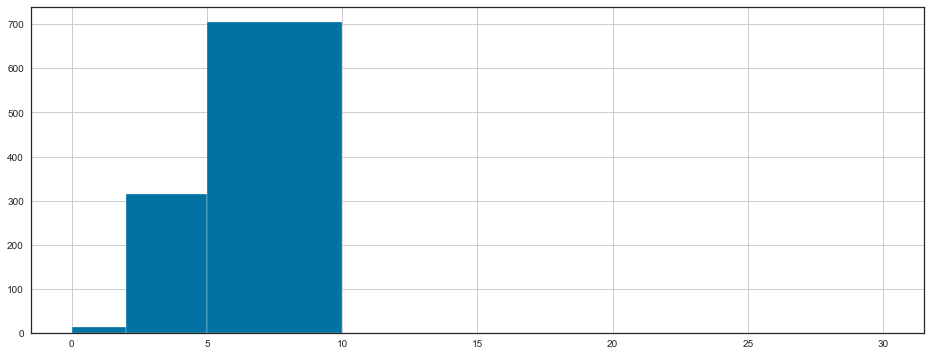

In [51]:
(df['Close'] - df['Adj Close']).hist(figsize=(16,6), bins=[0, 2, 5, 10, 15, 20, 30])

In [52]:
(df['Close'] - df['Adj Close']).describe()

count    1038.000000
mean        5.499913
std         9.748196
min       -33.025085
25%         3.777889
50%         5.693078
75%         6.516651
max       308.837845
dtype: float64

**Comments**
- This looks weird, but I'm not sure what's going on. I'm not comfortable using Adj Close until this is understood

### Check Signal Histogram

<AxesSubplot:>

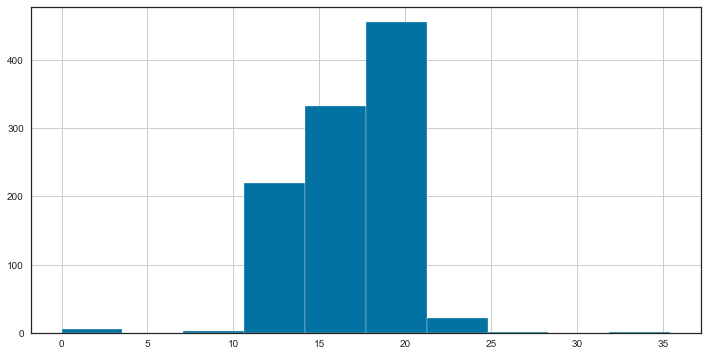

In [53]:
df['Signal'].hist(figsize=(12,6))

In [54]:
df['Signal'].describe()

count    1038.000000
mean       16.766190
std         3.095783
min         0.000000
25%        14.691150
50%        17.298240
75%        19.030890
max        35.434147
Name: Signal, dtype: float64

### Check Indexs of Zero Signal

In [55]:
df[df['Signal'] == 0.0].index

Int64Index([1032, 1033, 1034, 1035, 1036, 1037], dtype='int64')

**Comments**
- looks like an issue in signal calculation at for the last 6 rows. we should inform the signal provider and drop them for now. we could also fill forward the last real signal

### Check the Data for Max Signal

In [56]:
df[df['Signal'] == df['Signal'].max()].index

Int64Index([500], dtype='int64')

In [57]:
max_signal_iloc = df[df['Signal'] == df['Signal'].max()].index.values[0]
df.iloc[max_signal_iloc - 1: max_signal_iloc + 2] 

,Date,Signal,Open,High,Low,Close,Adj Close
499,2017-11-10,17.628384,146.710007,147.100006,146.350006,146.570007,140.810852
500,2017-11-13,35.434147,145.929993,146.820007,145.500000,146.610001,140.849274
501,2017-11-14,17.456319,146.059998,146.490005,145.589996,146.210007,140.465012


**Comments**
- looks like the max is an error. we should inform the signal provider and drop them for now. we could also fill forward the last real signal

### Check Close Histogram

<AxesSubplot:>

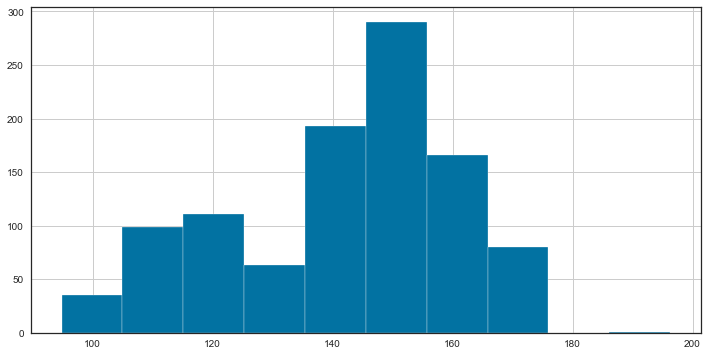

In [58]:
df['Close'].hist(figsize=(12,6))

In [59]:
max_close_iloc = df[df['Close'] == df['Close'].max()].index.values[0]
df.iloc[max_close_iloc - 1: max_close_iloc + 2]

,Date,Signal,Open,High,Low,Close,Adj Close
584,2018-03-16,19.385186,156.979996,158.270004,156.750000,157.800003,152.174042
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221
586,2018-03-20,19.177721,156.669998,157.020004,155.770004,156.240005,150.669647


**Comments**
- looks like the max close is an error... I'd recommend setting it to next days open so we can test it as a response variable 

### Check Open Histogram

<AxesSubplot:>

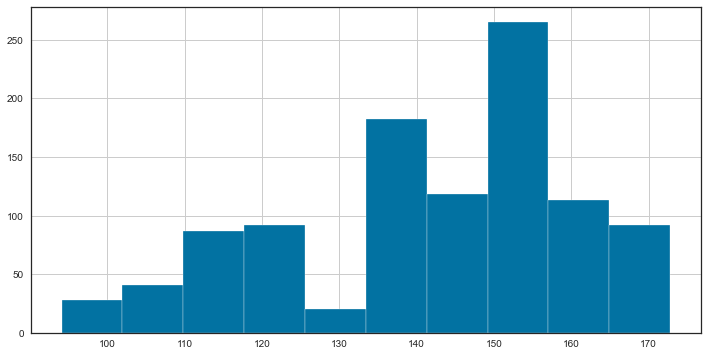

In [60]:
df['Open'].hist(figsize=(12,6))

### Check High, Low, Implied Rules
- High should be greater than Close, Open, and Low 
- Low should be less than Close, Open, and High

In [61]:
df[~(df['Close'] <= df['High'])]

,Date,Signal,Open,High,Low,Close,Adj Close
431,2017-08-07,16.298805,140.440002,140.350000,139.710007,140.440002,134.595871
585,2018-03-19,18.660897,157.169998,157.210007,154.449997,196.279999,150.708221
766,2018-12-06,16.904044,145.449997,147.099997,143.429993,147.199997,143.173874
983,2019-10-17,18.878412,152.289993,153.309995,152.050003,153.339996,151.102173


In [62]:
df[~(df['Open'] <= df['High'])]

,Date,Signal,Open,High,Low,Close,Adj Close
431,2017-08-07,16.298805,140.440002,140.35,139.710007,140.440002,134.595871


In [63]:
df[~(df['Close'] >= df['Low'])]

,Date,Signal,Open,High,Low,Close,Adj Close
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198
460,2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198
461,2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198
462,2017-09-20,15.953688,143.529999,144.020004,143.259995,139.110001,133.321198
463,2017-09-21,16.004491,144.020004,144.259995,143.479996,139.110001,133.321198
464,2017-09-22,16.997600,143.669998,144.669998,143.559998,139.110001,133.321198


In [64]:
df[(df['Close'] == 139.110001)]

,Date,Signal,Open,High,Low,Close,Adj Close
313,2017-02-17,16.635032,138.449997,139.160004,138.250000,139.110001,132.366592
453,2017-09-07,16.478500,139.589996,139.690002,138.589996,139.110001,133.321198
454,2017-09-08,15.518587,138.929993,139.770004,138.619995,139.110001,133.321198
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198
460,2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198
461,2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198


In [65]:
df[(df['Close'] == 139.110001) & ~(df['Close'] >= df['Low'])]

,Date,Signal,Open,High,Low,Close,Adj Close
455,2017-09-11,15.838558,140.389999,140.919998,140.229996,139.110001,133.321198
456,2017-09-12,15.518587,141.039993,141.690002,140.820007,139.110001,133.321198
457,2017-09-13,16.158529,141.410004,142.220001,141.320007,139.110001,133.321198
458,2017-09-14,16.478500,141.779999,142.160004,141.419998,139.110001,133.321198
459,2017-09-15,15.198617,141.639999,142.470001,141.550003,139.110001,133.321198
460,2017-09-18,15.518587,142.619995,143.809998,142.600006,139.110001,133.321198
461,2017-09-19,16.798471,143.570007,143.690002,143.089996,139.110001,133.321198
462,2017-09-20,15.953688,143.529999,144.020004,143.259995,139.110001,133.321198
463,2017-09-21,16.004491,144.020004,144.259995,143.479996,139.110001,133.321198
464,2017-09-22,16.997600,143.669998,144.669998,143.559998,139.110001,133.321198


**Comments**
- Close data looks to have been filled forward for several dates with 139.110001
- To use close as response variable I'd recommend filling it with the next days open for these instances 

In [66]:
df[~(df['Open'] >= df['Low'])]

,Date,Signal,Open,High,Low,Close,Adj Close
407,2017-07-04,15.282748,141.339996,142.600000,141.400003,142.200006,135.700998
577,2018-03-07,18.885411,154.460007,156.929993,157.220001,156.740005,151.151840
671,2018-07-16,20.010313,167.759995,168.029999,169.960007,166.770004,161.779312
892,2019-06-10,19.055083,151.449997,153.139999,152.449997,151.750000,148.488159


In [67]:
df[~(df['High'] >= df['Low'])]

,Date,Signal,Open,High,Low,Close,Adj Close
577,2018-03-07,18.885411,154.460007,156.929993,157.220001,156.740005,151.151840
671,2018-07-16,20.010313,167.759995,168.029999,169.960007,166.770004,161.779312


**Comments**
- High and Low data doesn't look reliable, but if we don't plan to use it we can disregard this for now
- The easiest HACK is to set Low = Open in these cases 

## Review Signal Predictive Power

### Preprocessing / Cleanup

In [68]:
# sort by date
df = df.sort_values(by='Date')

# shift open price forward 1 day
df['Open +1D'] = df['Open'].shift(1)

# Add Return Columns for a Stationary Response
df['Open +1D Return'] = df['Open +1D'].pct_change()
df['Close Return'] = df['Close'].pct_change()

# drop last 6 zero rows from signal
df = df[df['Signal'] != 0.0]

# drop highest value from Signal
df = df[df['Signal'] != df['Signal'].max()]

# fill the highest value of Close with the next mornings open
max_close_iloc = df[df['Close'] == df['Close'].max()].index.values[0]
df.loc[max_close_iloc, 'Close'] = df.loc[max_close_iloc+1, 'Open']

# adjusting the period where close is filled forward with the next days open price instead
df.loc[(df['Close'] == 139.110001) & ~(df['Close'] >= df['Low']), 'Close'] = df.loc[(df['Close'] == 139.110001) & ~(df['Close'] >= df['Low']), 'Open +1D']

# set date as index
df = df.set_index('Date')

### Predictor & Response

- x will be signal
- y_1 will be the cleaned up close column
- y_2 will be the naturally cleaner open column

Train & dev set will be split at 20% as there is not a huge amount of data points. The data will be split without shuffling to capture the most recent values in the dev set

In [75]:
x_1, y_1, y_2 = df['Signal'], df['Close'], df['Open +1D']

y_2 = y_2.dropna()
x_2 = x_1[y_2.index]

train_x_1, dev_x_1, train_y_1, dev_y_1 = train_test_split(x_1, y_1, test_size=0.2, shuffle=False)
train_x_2, dev_x_2, train_y_2, dev_y_2 = train_test_split(x_2, y_2, test_size=0.2, shuffle=False)

### Analysis

#### Signal vs Close Plot

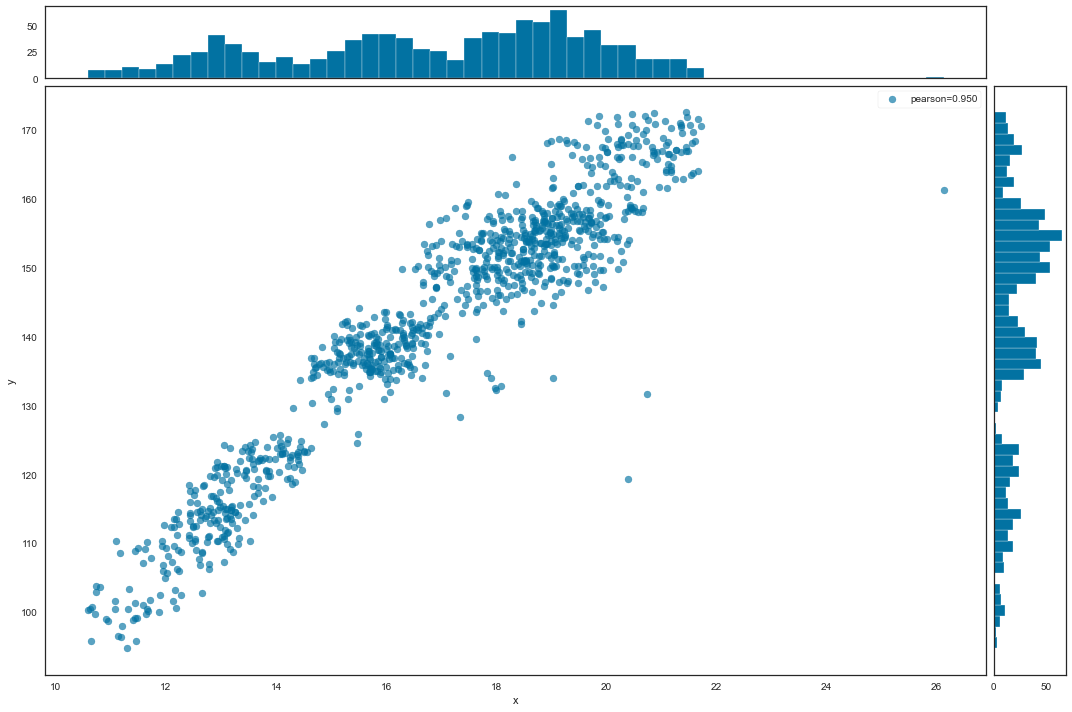

<AxesSubplot:xlabel='x', ylabel='y'>

In [76]:
visualizer = JointPlotVisualizer(size=(1080, 720))
visualizer.fit_transform(x_1, y_1)
visualizer.show()

#### Signal vs Open +1D Plot

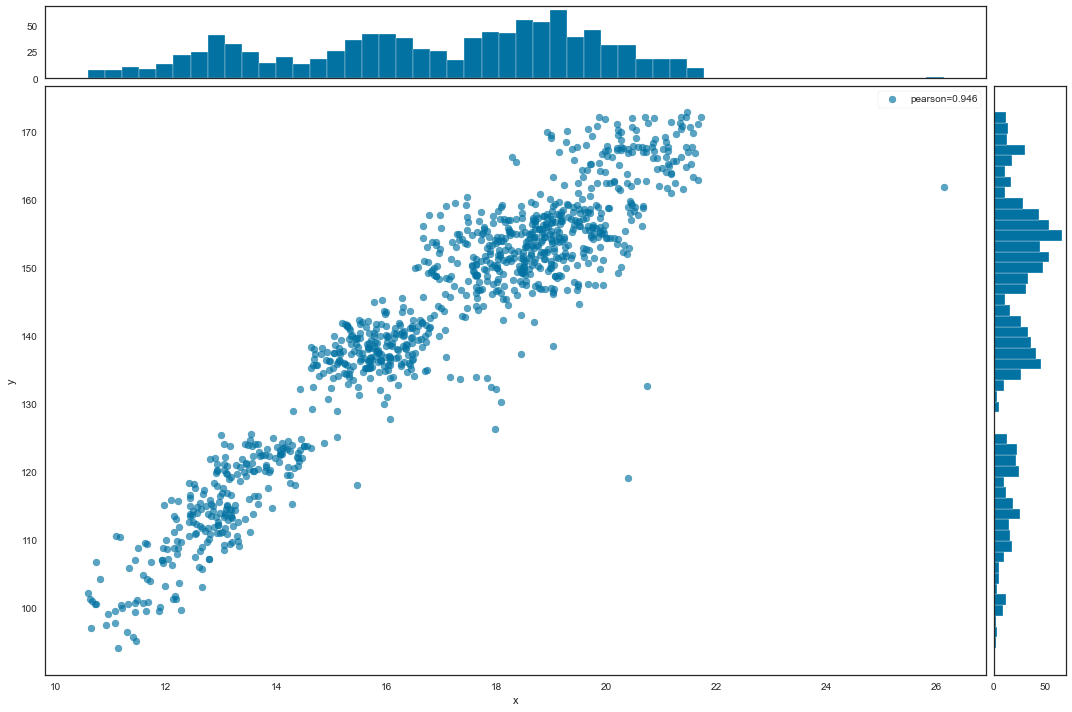

<AxesSubplot:xlabel='x', ylabel='y'>

In [77]:
visualizer = JointPlotVisualizer(size=(1080, 720))
visualizer.fit_transform(x_2, y_2)
visualizer.show()

#### Train a Simple Linear Regression and Evaluate Residual Plot

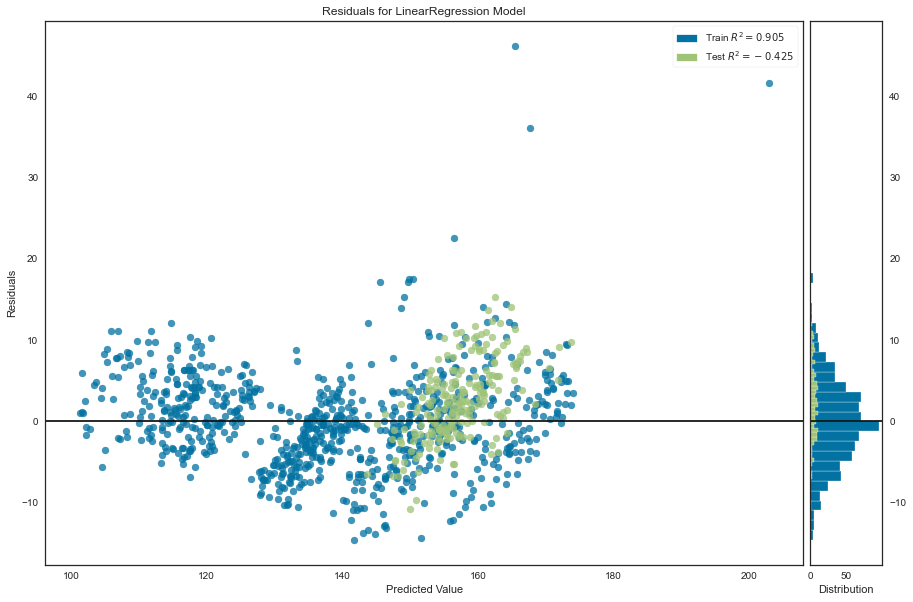

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [78]:
visualizer = ResidualsPlot(LinearRegression(),size=(1080, 720))
visualizer.fit(train_x_1.values.reshape(-1, 1), train_y_1.values.reshape(-1, 1))
visualizer.score(dev_x_1.values.reshape(-1, 1), dev_y_1.values.reshape(-1, 1))
visualizer.show()

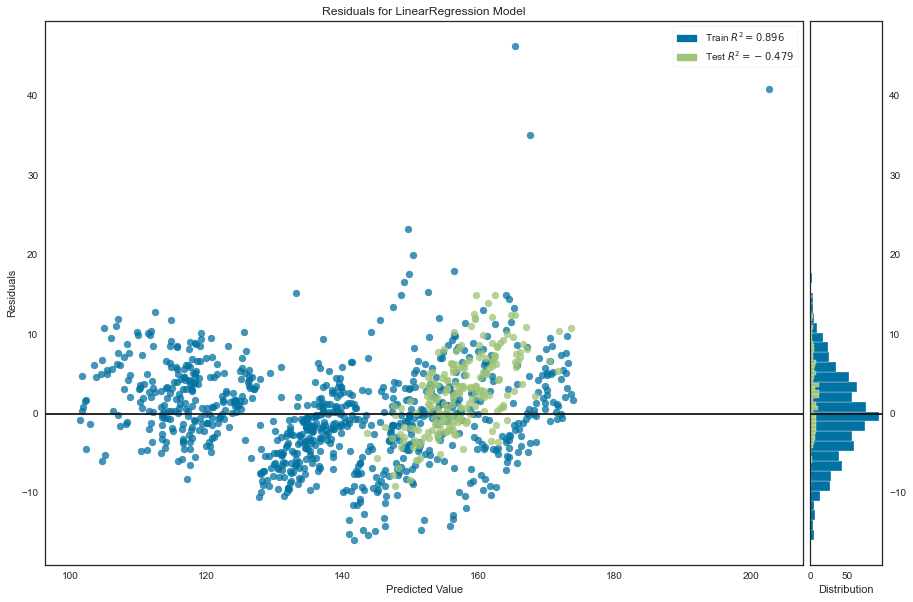

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [79]:
visualizer = ResidualsPlot(LinearRegression(),size=(1080, 720))
visualizer.fit(train_x_2.values.reshape(-1, 1), train_y_2.values.reshape(-1, 1))
visualizer.score(dev_x_2.values.reshape(-1, 1), dev_y_2.values.reshape(-1, 1))
visualizer.show()

#### Review Findings with Tree Models

- there are less statistical assumptions to violate, so is a good check on the linear

In [32]:
ebm = ExplainableBoostingRegressor()
ebm.fit(train_x_2.to_frame(), train_y_2)
rt = RegressionTree()
rt.fit(train_x_2.to_frame(), train_y_2)

In [33]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(dev_x_2.to_frame(), dev_y_2, name='Boosting Tree')
rt_perf = RegressionPerf(rt.predict).explain_perf(dev_x_2.to_frame(), dev_y_2, name='Regression Tree')

In [34]:
show(rt_perf)
show(ebm_perf)

<!-- http://127.0.0.1:7001/2766622033376/ -->

<!-- http://127.0.0.1:7001/2766622034096/ -->

#### Check Global Tree

In [35]:
ebm_global = ebm.explain_global(name='Boosting Tree')
rt_global = rt.explain_global(name='Regression Tree')

In [36]:
show(ebm_global)
show(rt_global)

<!-- http://127.0.0.1:7001/2766622408560/ -->

<!-- http://127.0.0.1:7001/2766666354592/ -->